# Dietary Analysis and Quality of Diets

In this notebook we explore the relationship between life quality, economic factors, and diet quality across countries.

## Research Questions

- $RQ_1$ How does diet impact life expectancy?
- $RQ_2$ How do economic factors impact the quality of diets in different countries?
- $RQ_3$ What are the main dietary patterns across regions and economic levels?
    
### Motivations

- $M_1$ Understand if higher economic prosperity and superior living conditions lead to better diet standards.
- $M_2$ Inform policy and health strategies by linking socio-economic development with nutrition.

### Hypotheses

- $H_1$ Diet has a measurable impact on life expectancy.
- $H_{2\_1}$ Countries with lower GDP and life expectancy will exhibit diets with higher ammounts of cereals and grains.
- $H_{2\_1}$ Countries with higher GDP and life expectancy will exhibit diets with higher ammounts of meats and sugars.

## Import Required Libraries
Import the necessary libraries, including pandas, numpy, and any libraries required for regression analysis.

In [ ]:
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
import plotly.graph_objects as go

sns.set_theme(style="whitegrid")

## Data Overview and Preprocessing

Load the cleaned dataset (which includes socio-economic and dietary data) and review its overall structure. In previous notebooks, similar steps were taken to process the data.

We are going to normalize some data and stratify the countries by GDP per capita.

In [ ]:
data: pl.DataFrame = pl.read_csv("../data/cleaned/data.csv", separator=",")
data = data.with_columns((pl.col("GDP") / pl.col("Population")).alias("GDP per capita"))
data.head()

Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban population,Latitude,Longitude,Median Salary,Code,Year,Daily calorie supply per person from other commodities,Daily calorie supply per person from alcoholic beverages,Daily calorie supply per person from sugar,Daily calorie supply per person from oils and fats,Daily calorie supply per person from meat,Daily calorie supply per person from dairy and eggs,Daily calorie supply per person from fruits and vegetables,Daily calorie supply per person from starchy roots,Daily calorie supply per person from pulses,Daily calorie supply per person from cereals and grains,Daily total caloric ingestion,GDP per capita
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Afghanistan""",60.0,"""AF""",58.1,652230.0,323000.0,32.49,8672.0,149.9,2.3,4.47,2.1,0.7,1.9101e10,104.0,9.7,47.9,64.5,638.0,78.4,0.28,3.8041754e7,48.9,9.3,71.4,11.12,9.797273e6,33.93911,67.709953,853.74,"""AFG""",2021,10.0,0.0,132.0,246.0,45.0,94.0,104.0,39.0,16.0,1512.0,2188.0,502.115487
"""Albania""",105.0,"""AL""",43.1,28748.0,9000.0,11.78,4536.0,119.05,1.4,1.62,28.1,1.36,1.5278e10,107.0,55.0,7.8,78.5,15.0,56.9,1.2,2.854191e6,55.7,18.6,36.6,12.33,1.747593e6,41.153332,20.168331,832.84,"""ALB""",2021,68.0,50.0,246.0,379.0,261.0,695.0,580.0,87.0,47.0,985.0,3330.0,5352.857411
"""Algeria""",18.0,"""DZ""",17.4,2.381741e6,317000.0,24.28,150006.0,151.36,2.0,3.02,0.8,0.28,1.6999e11,109.9,51.4,20.1,76.7,112.0,28.1,1.72,4.3053054e7,41.2,37.2,66.1,11.7,3.15101e7,28.033886,1.659626,1148.84,"""DZA""",2021,27.000002,5.0000005,295.00003,616.00006,99.00001,276.00003,393.00006,109.000015,61.000008,1616.0001,3470.000314,3948.343279
"""Andorra""",164.0,"""AD""",40.0,468.0,45891.309773,7.2,469.0,144.879813,8.811619,1.27,34.0,1.51,3.1541e9,106.4,52.571064,2.7,84.04,-38.781091,36.4,3.33,77142.0,62.61806,19.248343,39.426858,6.042134,67873.0,42.506285,1.521801,3668.08,null,2021,68.0,191.0,425.0,876.0,375.0,522.0,221.0,113.0,13.0,816.0,3552.0,40886.391162
"""Angola""",26.0,"""AO""",47.5,1.2467e6,117000.0,40.73,34693.0,261.73,17.1,5.52,46.3,0.97,9.4635e10,113.5,9.3,51.6,60.8,241.0,33.4,0.21,3.1825295e7,77.5,9.2,49.1,6.89,2.1061025e7,-11.202692,17.873887,284.39,"""AGO""",2021,14.999997,72.999985,131.99997,313.99994,126.99998,15.999997,128.99997,809.9999,66.999985,704.9999,2372.999627,2973.59116


In [ ]:
food_categories = [
    "Daily calorie supply per person from other commodities",
    "Daily calorie supply per person from sugar",
    "Daily calorie supply per person from oils and fats",
    "Daily calorie supply per person from meat",
    "Daily calorie supply per person from fruits and vegetables",
    "Daily calorie supply per person from starchy roots",
    "Daily calorie supply per person from pulses",
    "Daily calorie supply per person from cereals and grains",
    "Daily calorie supply per person from alcoholic beverages",
]

---

# $RQ_1$ How does diet impact life expectancy?

## Plan

1. **Stratify the Countries by GDP per Capita Based on Quantiles**:
   - We will divide the countries into different groups based on their GDP per capita using quantiles. This will help us isolate the effect of economic status on life expectancy and food quality.

2. **Analyze the Impact of Food Categories on Life Expectancy Using Regression Techniques**:
   - For each group of countries, we will analyze the impact of different food categories on life expectancy. We will use regression techniques to determine the relationship between diet and life expectancy.

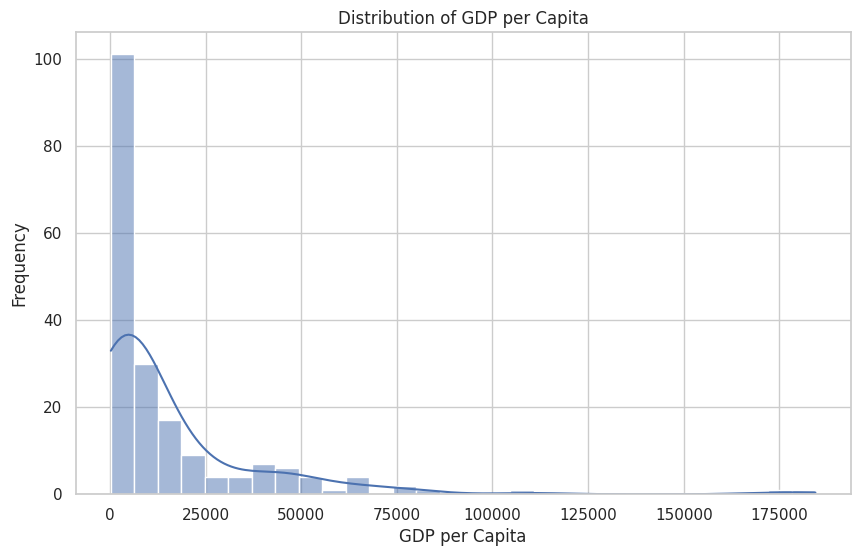

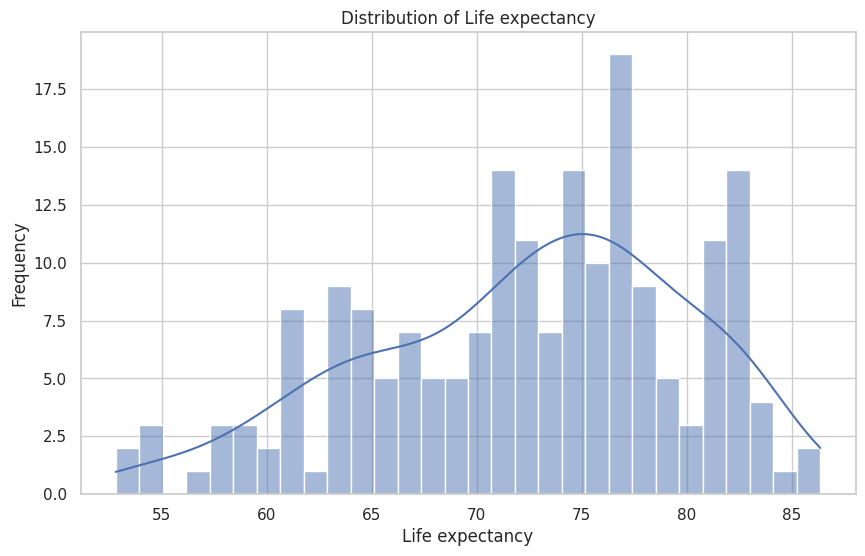

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data["GDP per capita"], bins=30, kde=True)
plt.title("Distribution of GDP per Capita")
plt.xlabel("GDP per Capita")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data["Life expectancy"], bins=30, kde=True)
plt.title("Distribution of Life expectancy")
plt.xlabel("Life expectancy")
plt.ylabel("Frequency")
plt.show()

From these visualzations, we can see that GDP per capita is not normally distributed. We will use quantiles to stratify the countries into different groups based on this.

In [ ]:
num_quantiles = 4

quantile_low = data.select(pl.quantile("GDP per capita", 0.25)).item()
quantile_mid = data.select(pl.quantile("GDP per capita", 0.5)).item()
quantile_high = data.select(pl.quantile("GDP per capita", 0.75)).item()

print(f"Low quantile: {quantile_low}")
print(f"Mid quantile: {quantile_mid}")
print(f"High quantile: {quantile_high}")

data = data.with_columns(
    pl.when(pl.col("GDP per capita") < quantile_low)
    .then(pl.lit("Very Low"))
    .when(pl.col("GDP per capita") < quantile_mid)
    .then(pl.lit("Low"))
    .when(pl.col("GDP per capita") < quantile_high)
    .then(pl.lit("Mid"))
    .otherwise(pl.lit("High"))
    .alias("GDP per capita quantile")
)

data.head()

Low quantile: 1912.903745350624
Mid quantile: 5955.109010370268
High quantile: 17401.72151600512


Country,Density(P/Km2),Abbreviation,Agricultural Land(%),Land Area(Km2),Armed Forces size,Birth Rate,Co2-Emissions,CPI,CPI Change (%),Fertility Rate,Forested Area (%),Gasoline Price,GDP,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban population,Latitude,Longitude,Median Salary,Code,Year,Daily calorie supply per person from other commodities,Daily calorie supply per person from alcoholic beverages,Daily calorie supply per person from sugar,Daily calorie supply per person from oils and fats,Daily calorie supply per person from meat,Daily calorie supply per person from dairy and eggs,Daily calorie supply per person from fruits and vegetables,Daily calorie supply per person from starchy roots,Daily calorie supply per person from pulses,Daily calorie supply per person from cereals and grains,Daily total caloric ingestion,GDP per capita,GDP per capita quantile
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""Afghanistan""",60.0,"""AF""",58.1,652230.0,323000.0,32.49,8672.0,149.9,2.3,4.47,2.1,0.7,1.9101e10,104.0,9.7,47.9,64.5,638.0,78.4,0.28,3.8041754e7,48.9,9.3,71.4,11.12,9.797273e6,33.93911,67.709953,853.74,"""AFG""",2021,10.0,0.0,132.0,246.0,45.0,94.0,104.0,39.0,16.0,1512.0,2188.0,502.115487,"""Very Low"""
"""Albania""",105.0,"""AL""",43.1,28748.0,9000.0,11.78,4536.0,119.05,1.4,1.62,28.1,1.36,1.5278e10,107.0,55.0,7.8,78.5,15.0,56.9,1.2,2.854191e6,55.7,18.6,36.6,12.33,1.747593e6,41.153332,20.168331,832.84,"""ALB""",2021,68.0,50.0,246.0,379.0,261.0,695.0,580.0,87.0,47.0,985.0,3330.0,5352.857411,"""Low"""
"""Algeria""",18.0,"""DZ""",17.4,2.381741e6,317000.0,24.28,150006.0,151.36,2.0,3.02,0.8,0.28,1.6999e11,109.9,51.4,20.1,76.7,112.0,28.1,1.72,4.3053054e7,41.2,37.2,66.1,11.7,3.15101e7,28.033886,1.659626,1148.84,"""DZA""",2021,27.000002,5.0000005,295.00003,616.00006,99.00001,276.00003,393.00006,109.000015,61.000008,1616.0001,3470.000314,3948.343279,"""Low"""
"""Andorra""",164.0,"""AD""",40.0,468.0,45891.309773,7.2,469.0,144.879813,8.811619,1.27,34.0,1.51,3.1541e9,106.4,52.571064,2.7,84.04,-38.781091,36.4,3.33,77142.0,62.61806,19.248343,39.426858,6.042134,67873.0,42.506285,1.521801,3668.08,null,2021,68.0,191.0,425.0,876.0,375.0,522.0,221.0,113.0,13.0,816.0,3552.0,40886.391162,"""High"""
"""Angola""",26.0,"""AO""",47.5,1.2467e6,117000.0,40.73,34693.0,261.73,17.1,5.52,46.3,0.97,9.4635e10,113.5,9.3,51.6,60.8,241.0,33.4,0.21,3.1825295e7,77.5,9.2,49.1,6.89,2.1061025e7,-11.202692,17.873887,284.39,"""AGO""",2021,14.999997,72.999985,131.99997,313.99994,126.99998,15.999997,128.99997,809.9999,66.999985,704.9999,2372.999627,2973.59116,"""Low"""


In [ ]:
def update_choropleth(col):
    fig = px.choropleth(
        data.to_pandas(),
        locations="Country",
        locationmode="country names",
        color=col,
        hover_name="Country",
        color_continuous_scale="Viridis",
        projection="natural earth",
        title=f"{col} per country",
    )
    fig.update_geos(showcoastlines=True, coastlinecolor="Black")
    fig.update_layout(margin={"r": 0, "t": 50, "l": 0, "b": 0})
    fig.show()


columns_options = data.columns
interact(
    update_choropleth,
    col=widgets.Dropdown(options=columns_options, description="Select Column:"),
)

interactive(children=(Dropdown(description='Select Column:', options=('Country', 'Density(P/Km2)', 'Abbreviati…

<function __main__.update_choropleth(col)>

In [ ]:
update_choropleth("GDP per capita quantile")

### Check relationship between GDP per capita, life expectancy, and diet quality

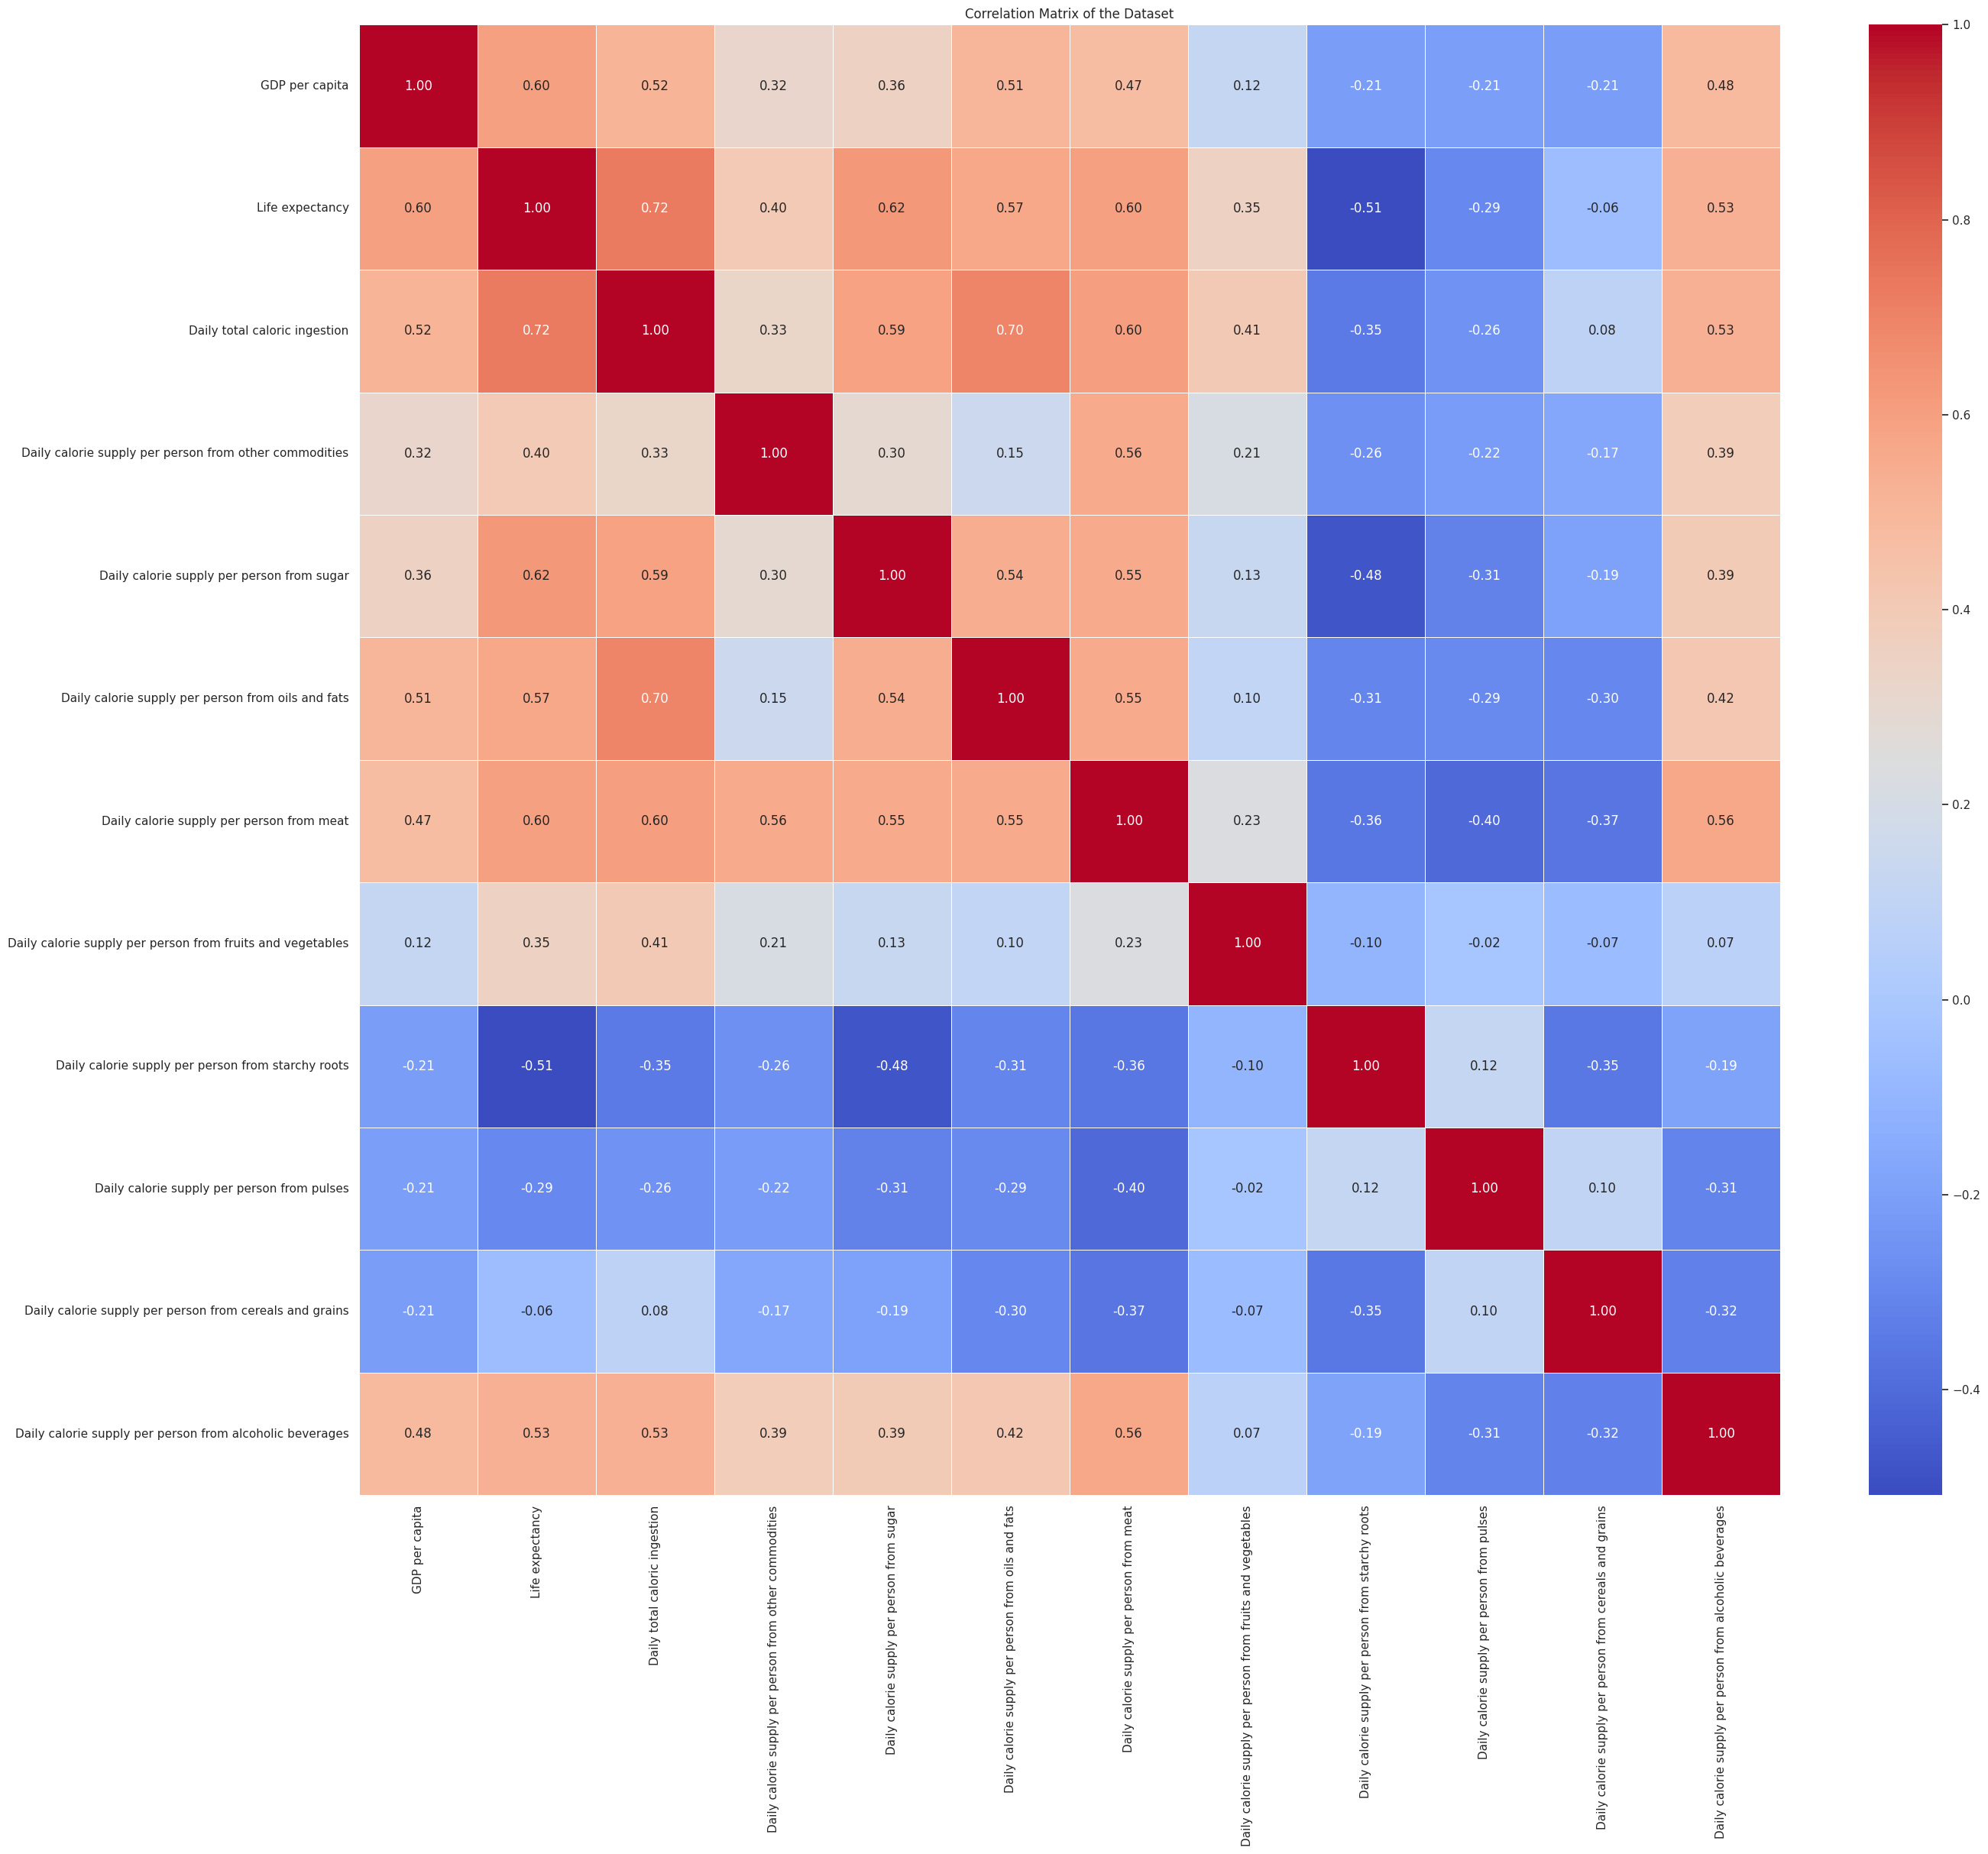

In [ ]:
correlation_df = data.select(
    [
        "GDP per capita",
        "Life expectancy",
        "Daily total caloric ingestion",
        *food_categories,
    ]
)

correlation_matrix = correlation_df.to_pandas().corr()

plt.figure(figsize=(30, 25))
sns.heatmap(
    data=correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5
)
plt.title(label="Correlation Matrix of the Dataset")
plt.show()

We start to see some indicators in the data that may suggest that diet is not directly related to life expectancy as we had expected, but rather it being influenced by the economic status of the country. We are going to analyze this further by doing the following:
- First, we are going to see the difference in correlation in the different stratified groups.
- Second, we will try, as there migth be some intricacies in how these variables correlate, to use regression analysis to see if we can predict both life expectancy and GDP per capita based on the diet, we will explain how further in the notebook.

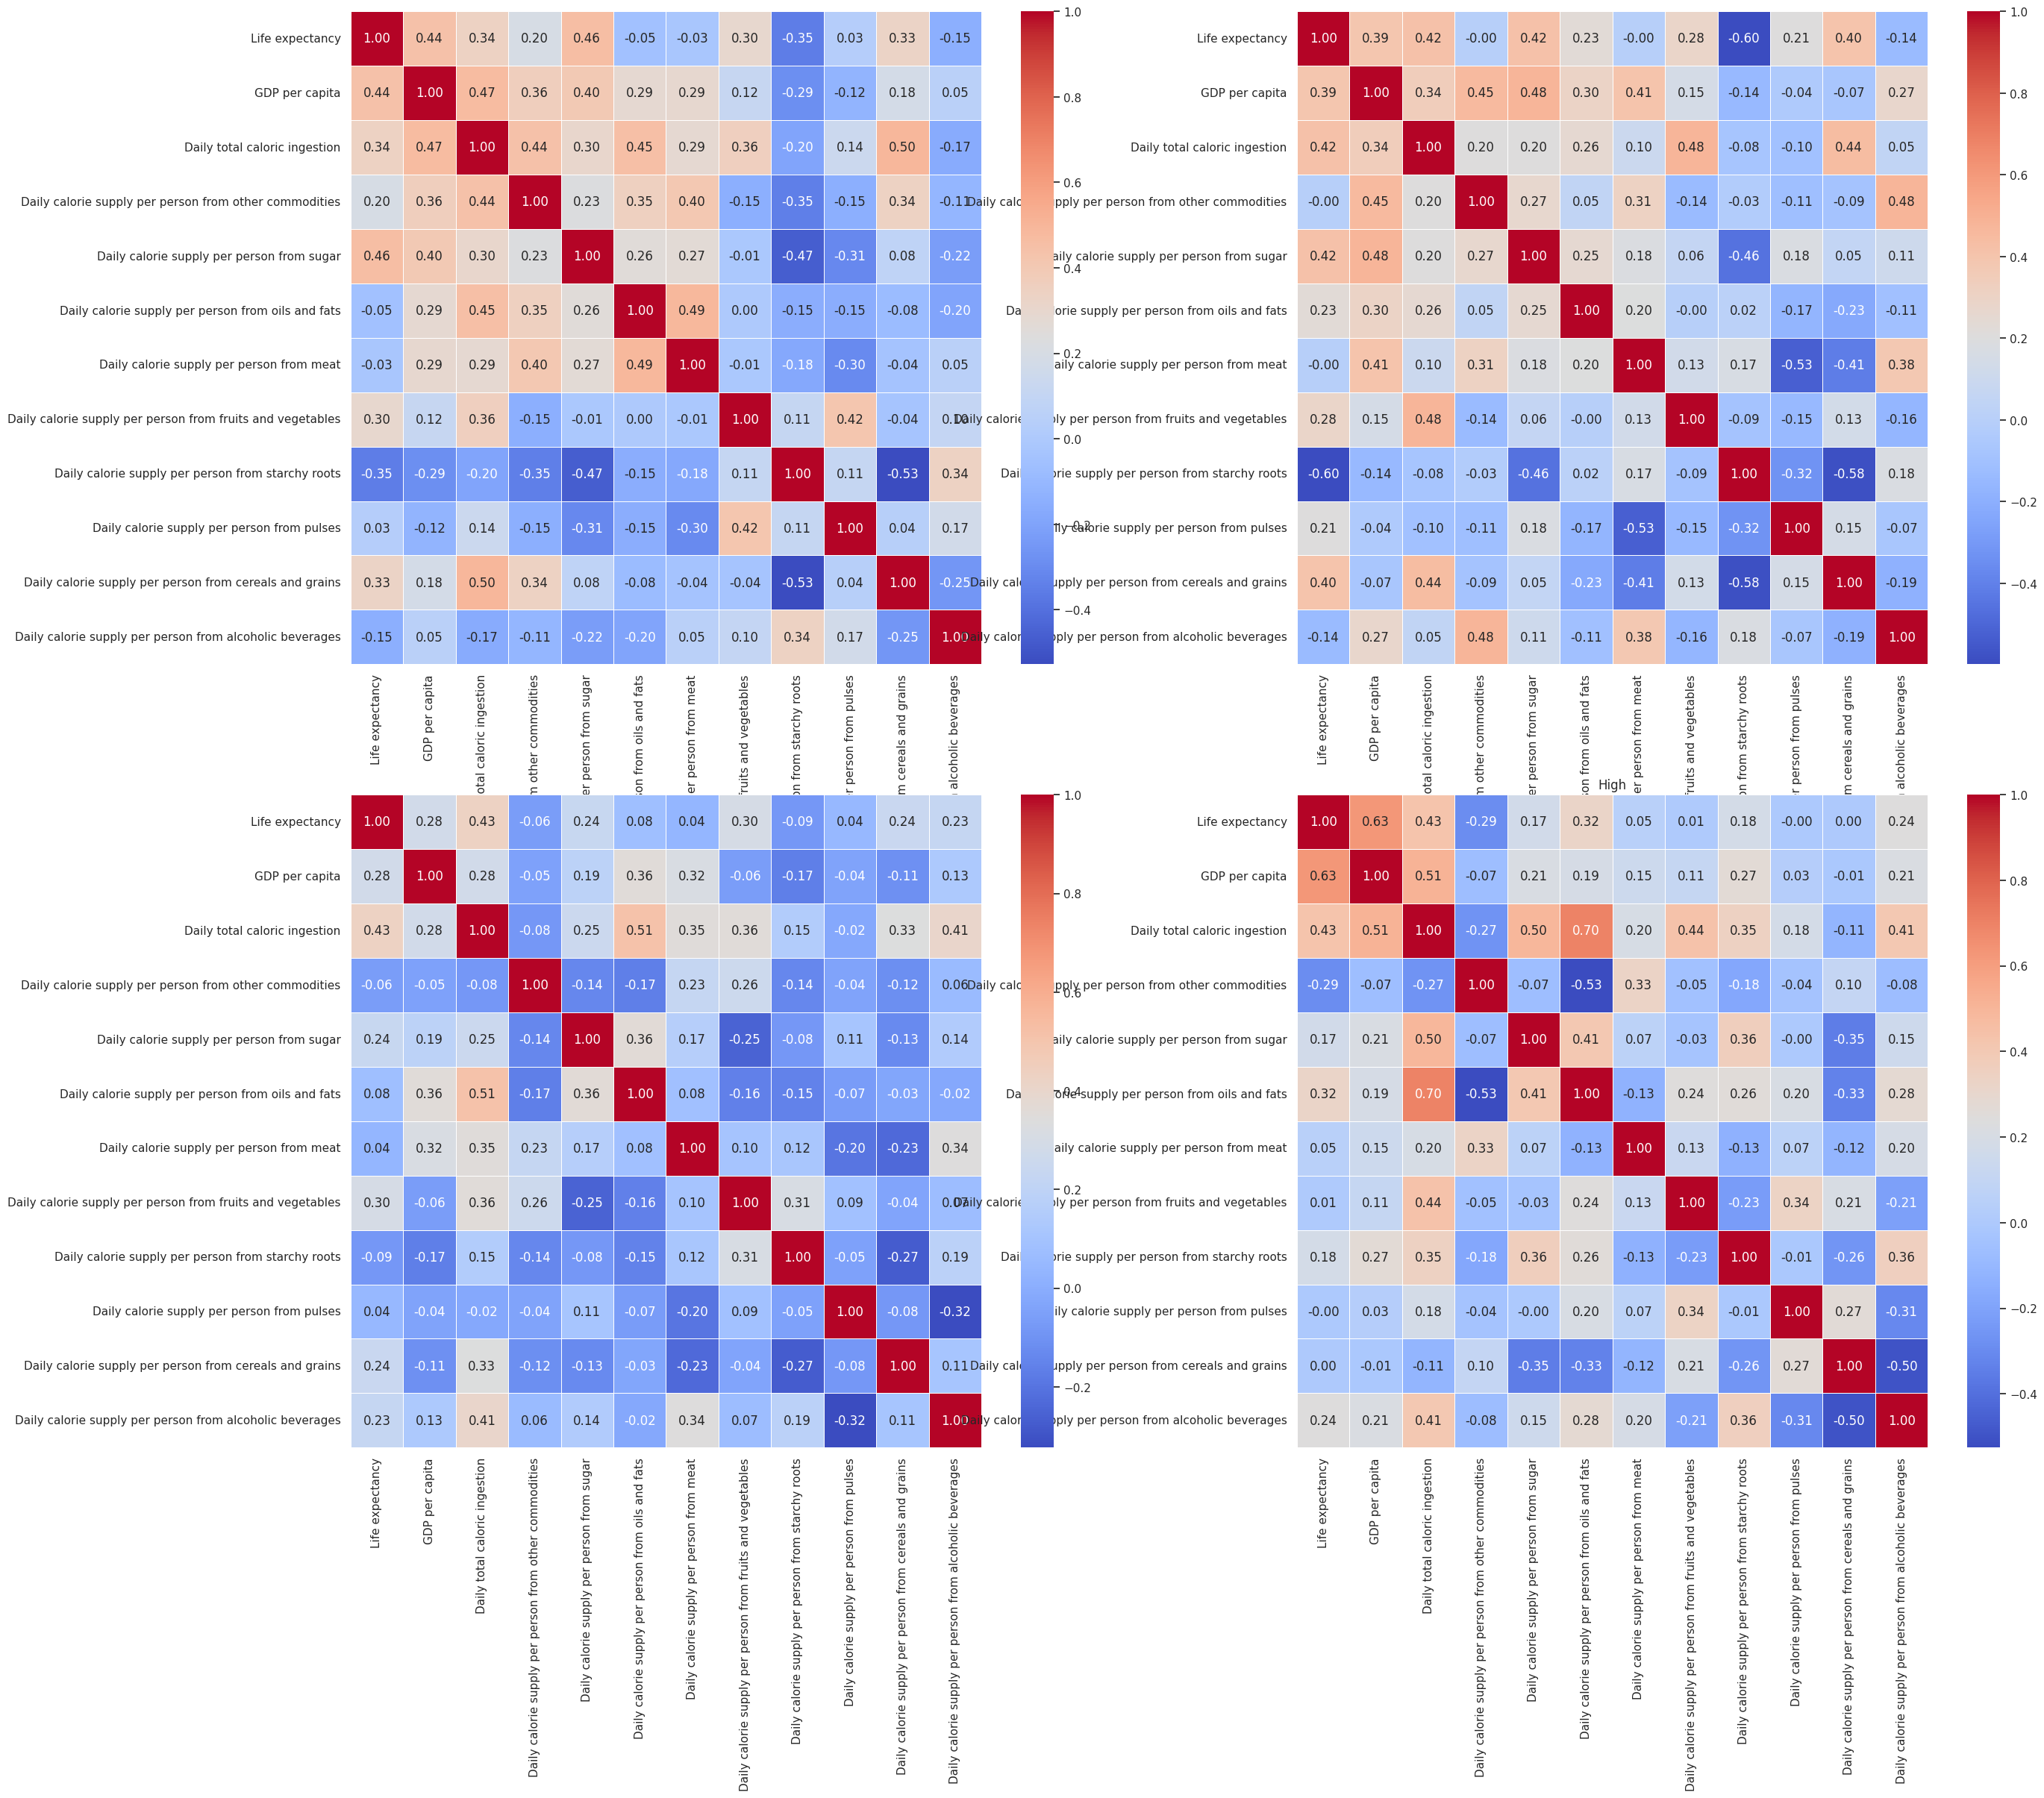

In [ ]:
very_low_gdp = data.filter(pl.col("GDP per capita quantile") == "Very Low")
low_gdp = data.filter(pl.col("GDP per capita quantile") == "Low")
mid_gdp = data.filter(pl.col("GDP per capita quantile") == "Mid")
high_gdp = data.filter(pl.col("GDP per capita quantile") == "High")

# Need 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(30, 25))

for axes, quantile in zip(
    [[0, 0], [0, 1], [1, 0], [1, 1]], [very_low_gdp, low_gdp, mid_gdp, high_gdp]
):
    correlation_df = quantile.select(
        [
            "Life expectancy",
            "GDP per capita",
            "Daily total caloric ingestion",
            *food_categories,
        ]
    )

    correlation_matrix = correlation_df.to_pandas().corr(method="spearman")

    sns.heatmap(
        data=correlation_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        linewidths=0.5,
        ax=axs[*axes],
    )
    plt.title(f"{quantile.select('GDP per capita quantile').unique().item()}")


plt.show()

So it does indeed seem that for similar GDP the diet does not have a significant impact on anything, as the prior 0.74 correlation between calory intake and life expectancy is now way lower. We can try to figure out visually whether we are in the right or not by plotting the data.

First we need to check whether we have enough variation in the data within same groups.

In [ ]:
def plot_violin(food_category):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x="GDP per capita quantile", y=food_category, data=data.to_pandas())
    plt.title(f"Violin Plot of {food_category} by GDP per Capita Quantile")
    plt.xlabel("GDP per Capita Quantile")
    plt.ylabel(food_category)
    plt.show()


interact(
    plot_violin,
    food_category=widgets.Dropdown(
        options=[*food_categories, "Life expectancy"], description="Food Category:"
    ),
)

interactive(children=(Dropdown(description='Food Category:', options=('Daily calorie supply per person from ot…

<function __main__.plot_violin(food_category)>

It does seem that we have enough variation indeed for all groups, so maybe the correlation is not the best way to analyze this data as there might be some intricacies in how these variables correlate. We will try to use regression analysis to see if we can predict life expectancy within the same group based on the diet, to see if there is a significant impact.


Results for Quantile Very Low: MSE = 33.62, R2 = -0.70, Best Degree = 2

Results for Quantile Low: MSE = 26.35, R2 = -0.02, Best Degree = 2

Results for Quantile Mid: MSE = 26.75, R2 = -0.92, Best Degree = 2

Results for Quantile High: MSE = 13.61, R2 = -0.62, Best Degree = 3


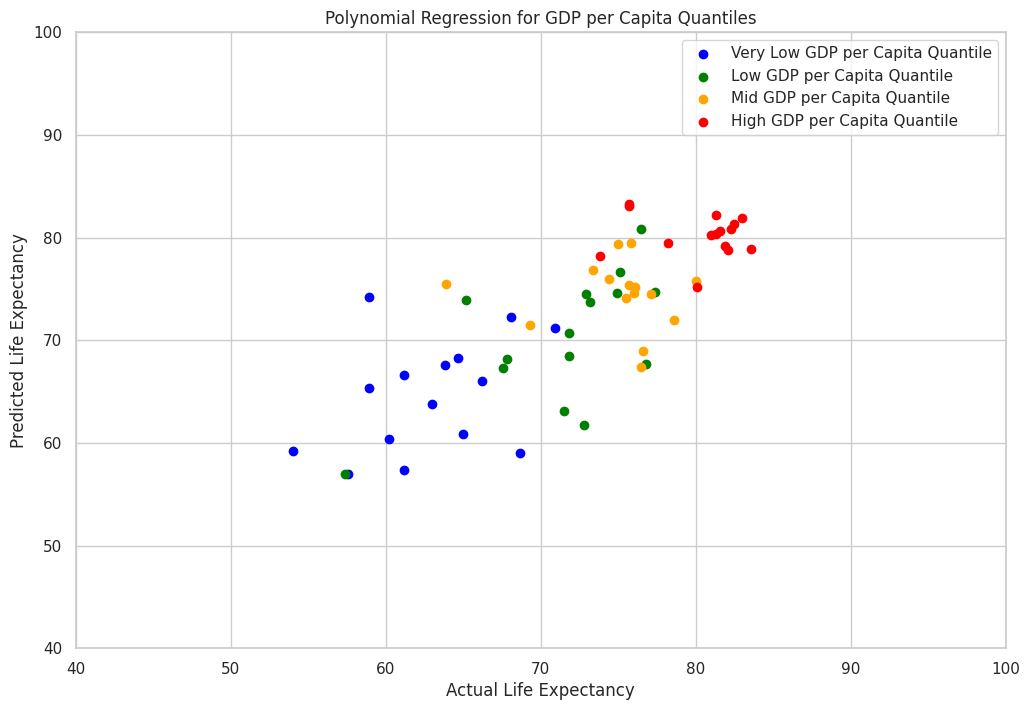

In [ ]:
import warnings

param_grid = {
    "polynomialfeatures__degree": [2, 3],
    "ridge__alpha": [0.1, 1, 10],
    "ridge__solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"],
}
poly_regression_results = {}

for quantile in ["Very Low", "Low", "Mid", "High"]:
    warnings.filterwarnings("ignore")

    quantile_data = data.filter(pl.col("GDP per capita quantile") == pl.lit(quantile))
    X = quantile_data[food_categories].to_pandas()
    y = quantile_data["Life expectancy"].to_pandas()

    pipeline = make_pipeline(PolynomialFeatures(), Ridge())

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    poly_regression_results[f"Quantile {quantile}"] = {
        "MSE": mse,
        "R2": r2,
        "Best Degree": grid_search.best_params_["polynomialfeatures__degree"],
        "y_test": y_test,
        "y_pred": y_pred,
    }

for quantile, metrics in poly_regression_results.items():
    print(
        f"\nResults for {quantile}: MSE = {metrics['MSE']:.2f}, R2 = {metrics['R2']:.2f}, Best Degree = {metrics['Best Degree']}"
    )

plt.figure(figsize=(12, 8))

colors = {"Very Low": "blue", "Low": "green", "Mid": "orange", "High": "red"}

for quantile in ["Very Low", "Low", "Mid", "High"]:
    y_test = poly_regression_results[f"Quantile {quantile}"]["y_test"]
    y_pred = poly_regression_results[f"Quantile {quantile}"]["y_pred"]
    plt.scatter(
        y_test,
        y_pred,
        color=colors[quantile],
        label=f"{quantile} GDP per Capita Quantile",
    )

plt.title("Polynomial Regression for GDP per Capita Quantiles")
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.xlim(40, 100)
plt.ylim(40, 100)
plt.legend()
plt.show()

## Conclusion

As we can see we could not obtain a significant model for any of the groups (negative r² values mean that a straight line fits the data best than the model) even with advanced regression techniques and a thorough grid search for hyperparameters, so it seems that overall factors of the diet does not have a significant impact on the life expectancy of a population. Now this is not to say that diet does not have an impact on life expectancy, but rather that the overall factors of a society or cultural diets, such as mediterranean, assian, etc. don't seem to directly correlate with life expectancy. So what can we extract from this then?
- We are not able to prove or disprove that there are superior diets that lead to longer life expectancy based solely on per country data.
- We can see that there is a significant correlation between GDP per capita and life expectancy, which was a side effect of the data we had, but it is not the main focus of this notebook.
- We see an overall increment of calory intake with GDP per capita, which is expected as richer countries tend to have more access to food, but further details on this relationship are to be explored in the next $RQ$

Unfortunately, as we could not find any particular relationship between diet and life expectancy, we are not able to provide further insights on which balance of food is the best for a longer life expectancy. This means that our initial hypothesis $H_1$ is not supported by the data.

---

# $RQ_2$ How do economic factors impact the quality of diets in different countries?

For this question the inmidiate intuition is to plot data based on the stratified groups and see if there is any significant difference in the diet of countries with different GDP per capita. We aim to do these visualizations to respond to the question:
- Boxplot of the different food categories for each group of countries.
- Compare total calory intake for each group of countries.
- Compare via radar plots the diet of countries in different groups.

Now, to accurately compare these values we are going to do both comparison on absulute values and on normalized values, as the total calory intake is expected to be higher in richer countries. This way we will also be able to observe the impact of GDP per capita on diet balance.

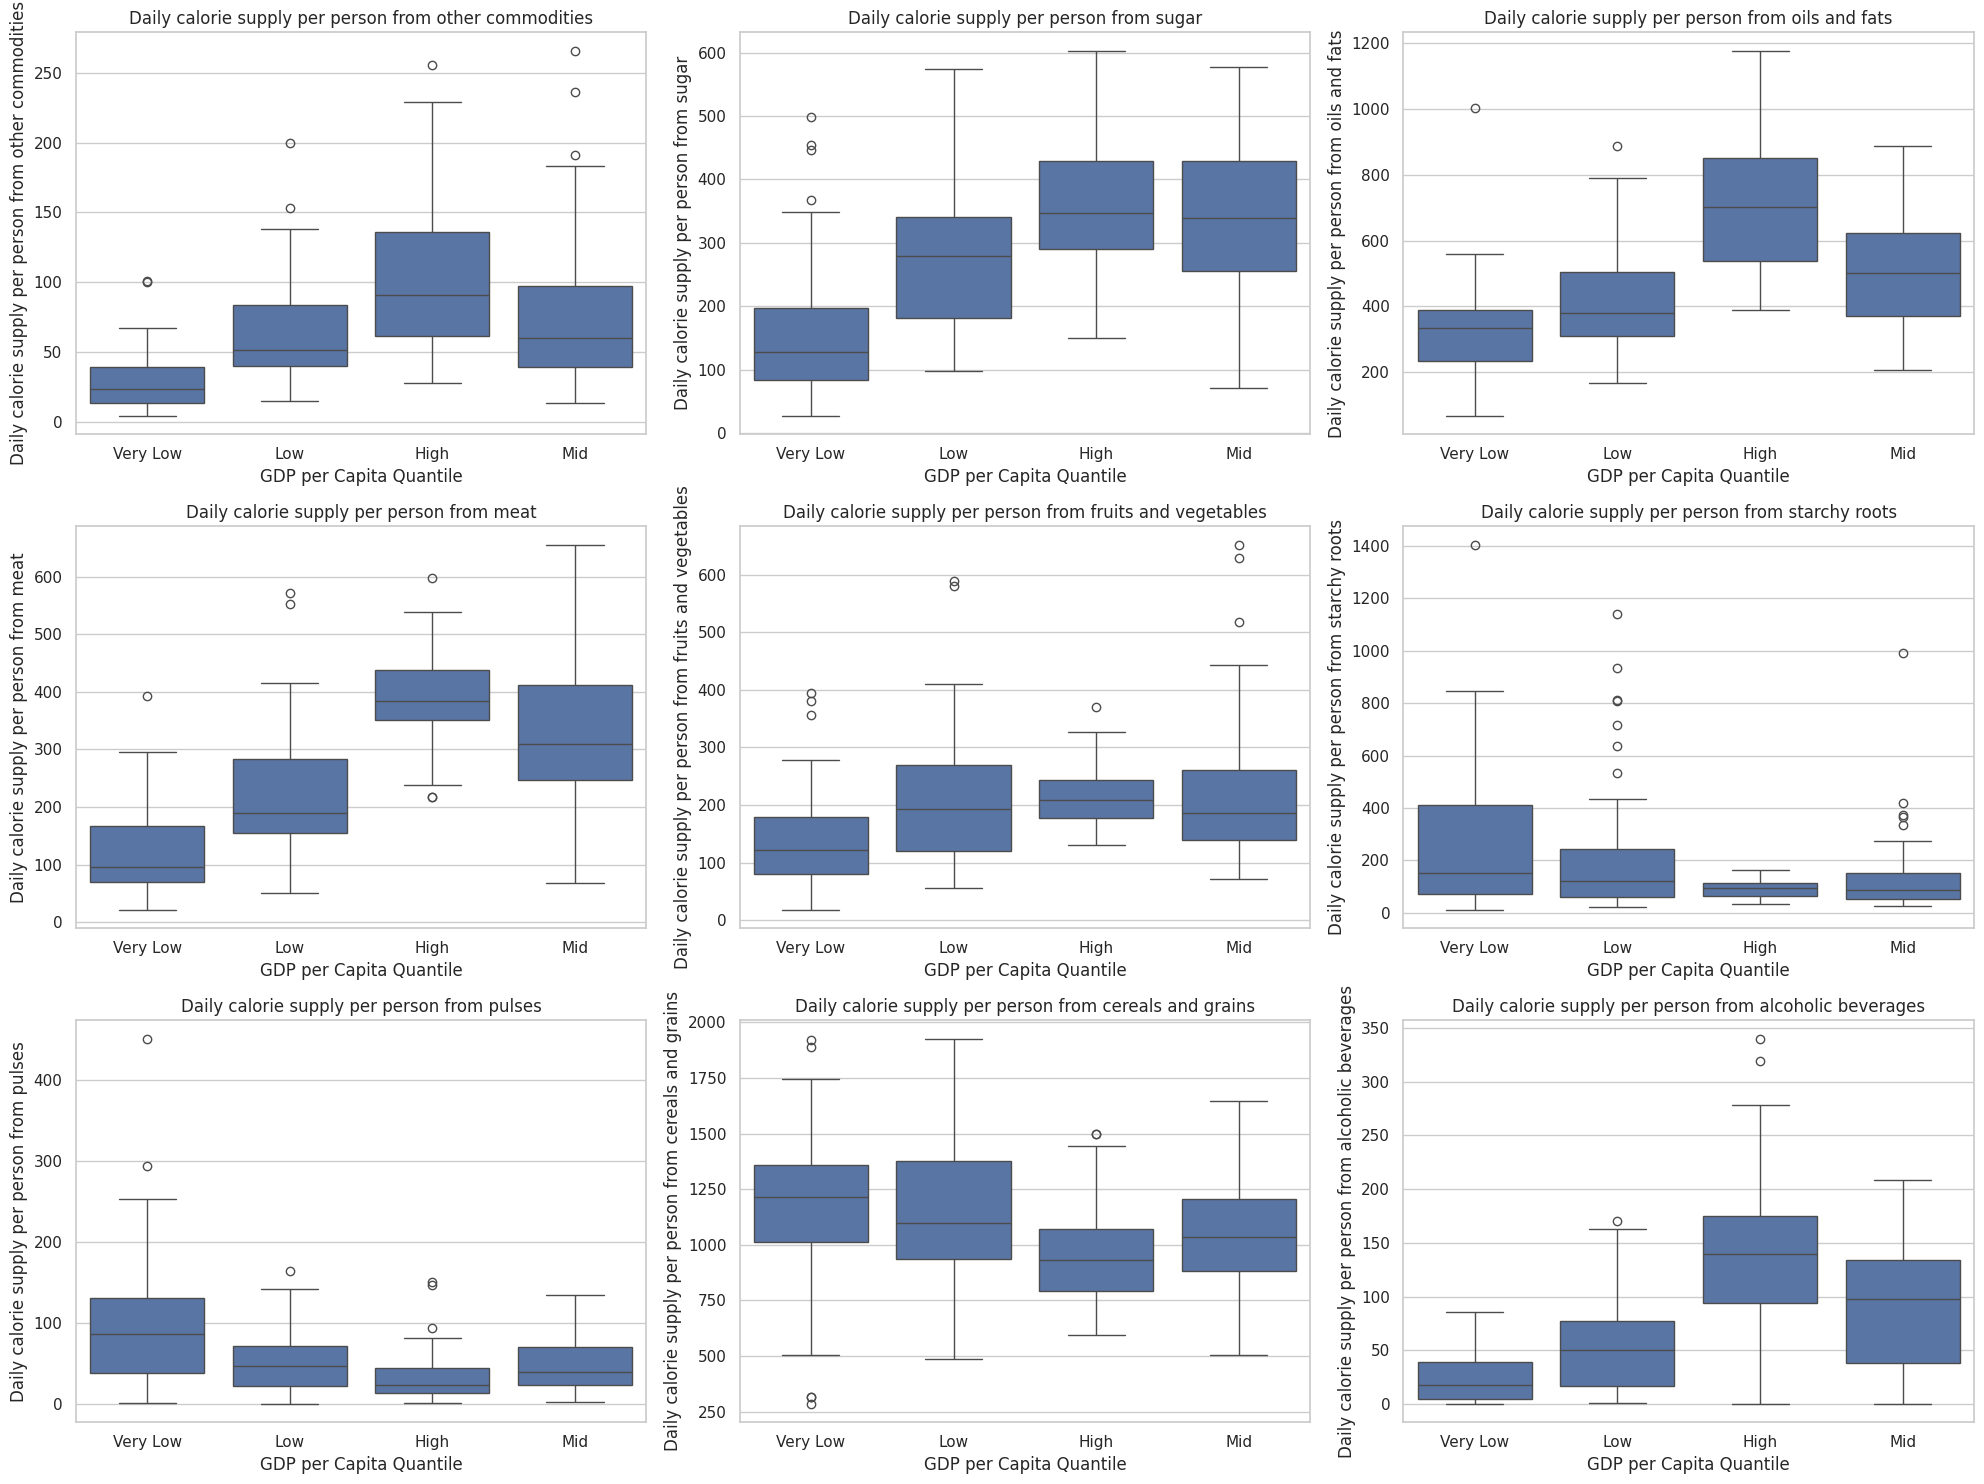

In [ ]:
plt.figure(figsize=(20, 15))
for i, category in enumerate(food_categories):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x="GDP per capita quantile", y=category, data=data.to_pandas())
    plt.title(f"{category}")
    plt.xlabel("GDP per Capita Quantile")
    plt.ylabel(category)
plt.tight_layout()
plt.show()

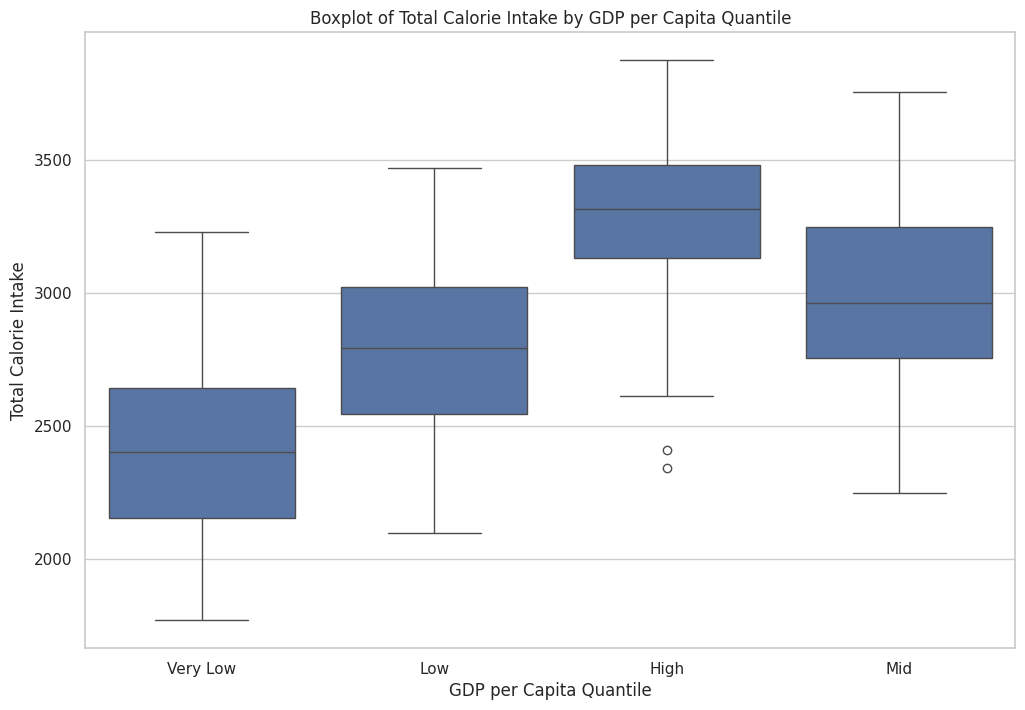

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="GDP per capita quantile",
    y="Daily total caloric ingestion",
    data=data.to_pandas(),
)
plt.title("Boxplot of Total Calorie Intake by GDP per Capita Quantile")
plt.xlabel("GDP per Capita Quantile")
plt.ylabel("Total Calorie Intake")
plt.show()

At first sight it looks like almost every food type is consumed more in richer countries, except for cereals, pulses, and starchy roots which are the opossite. However this may not be the best way to visualize this data, although it serves to see the distribution. Let's try with a radar plot instead.

In [ ]:
fig = go.Figure()

colors = {"Very Low": "blue", "Low": "green", "Mid": "orange", "High": "red"}

for quantile in ["Very Low", "Low", "Mid", "High"]:
    group_data: pl.DataFrame = data.filter(
        pl.col("GDP per capita quantile") == quantile
    )
    mean_values = (
        group_data.select(food_categories).median().to_pandas().values.flatten()
    )

    fig.add_trace(
        go.Scatterpolar(
            r=mean_values,
            theta=food_categories,
            fill=None,
            name=quantile,
            line_color=colors[quantile],
        )
    )

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, max(mean_values)])),
    showlegend=True,
    title="Radar Plot of Diet by GDP per Capita Quantile",
)

fig.show()

It does indeed look like what we saw before. However this can be misleading as the total calory intake is higher in richer countries, so we are going to normalize the data to see if there is any significant difference in the diet balance. We do this by dividing the values by the total calory intake of the country.

In [ ]:
def radar_plot_normalized():
    fig = go.Figure()
    colors = {"Very Low": "blue", "Low": "green", "Mid": "orange", "High": "red"}

    for group in ["Very Low", "Low", "Mid", "High"]:
        group_data = data.filter(pl.col("GDP per capita quantile") == group)
        mean_values = (
            group_data.select(food_categories).mean().to_pandas().values.flatten()
        )
        normalized_values = mean_values / mean_values.sum()

        fig.add_trace(
            go.Scatterpolar(
                r=normalized_values,
                theta=food_categories,
                name=group,
                line_color=colors[group],
            )
        )

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 0.6])),
        showlegend=True,
        title="Normalized Radar Plot of Diet by GDP per Capita Quantile",
    )

    fig.show()


radar_plot_normalized()

The cereal category makes it harder to read the data, so we are going to remove it from the radar plot.

In [ ]:
def radar_plot_normalized():
    fig = go.Figure()
    colors = {"Very Low": "blue", "Low": "green", "Mid": "orange", "High": "red"}

    for group in ["Very Low", "Low", "Mid", "High"]:
        group_data = data.filter(pl.col("GDP per capita quantile") == group)
        selected_columns = [
            category
            for category in food_categories
            if category != "Daily calorie supply per person from cereals and grains"
        ]
        mean_values = (
            group_data.select(selected_columns).mean().to_pandas().values.flatten()
        )
        normalized_values = mean_values / mean_values.sum()

        fig.add_trace(
            go.Scatterpolar(
                r=normalized_values,
                theta=selected_columns,
                name=group,
                line_color=colors[group],
            )
        )

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 0.4])),
        showlegend=True,
        title="Normalized Radar Plot of Diet by GDP per Capita Quantile",
    )

    fig.show()


radar_plot_normalized()

## Conclusion

The measurable differences seem to be:
- Countries with a high GDP per capita consume mosre fats and oils. Countries with a GDP lower than that don't seem to have much difference between them.
- The higher the income, the more meat is consumed proportionally, although countries with mid and high GDP per capita have a similar consumption.
- Starchy roots seem to be consumed more in countries with lower GDP per capita. The more money a country has, the less starchy roots are consumed, although this could be due to diet differences as most of the countries with low GDP per capita are in Africa. Something similar happens with cereals and grain. Although it is noteworthy that the consumpition of this last food type is the most prevalent across all countries.
- Pulses seem to be mostly consumed in countries with very low GDP per capita. In this case these are the only countries that show a consuption of this kind of food, so we are more inclined to think that this is a cultural thing rather than an economic one.
- Sugar seems to almost double in consupmtion in countries where the GDP per capita is higher than the "Very Low". But as it's increment is only shown in the lower consumption by the "Very Low" group, we are more inclined to think that this may have to do with how food is processed and distributed in developed and developing countries.
- Other than that, the consumption of fruits and vegetables, and other commodities do not seem to have a significant difference between countries with different GDP per capita.

In the end, the difference does not seem as big as we would have expected, but it is still significant. This means that our hypothesis $H_{2\_1}$ is supported by the data, but $H_{2\_2}$ is not, or at least, it's only partially supported, as we assumed that both the consumption of meat and sugar would increase with GDP per capita, but only meat consumption seems to have a significant increment related to GDP per capita.